In [1]:
import numpy as np
import sbmexplib
import matplotlib.pyplot as plt
import itertools

plt.rcParams['figure.figsize'] = (10,10)

%matplotlib inline

In [2]:
EDGE_PROBABILITIES = np.array([
        [.7, .3],
        [.3, .7]
    ])
SIZES = 2**np.arange(5,12)
N_TRIALS = [10] * len(SIZES)
MODELS = []

for size in SIZES:
    # block_sizes = sbmexplib.scaled_two_block_sizes(size, lambda n: n**.5)
    # block_sizes = sbmexplib.scaled_two_block_sizes(size, np.sqrt)
    block_sizes = [size//2, size - size//2]
    model = sbmexplib.Model(EDGE_PROBABILITIES, block_sizes)
    MODELS.append(model)
    
DATA_EIGENVALUES = []
DATA_EIGENVECTORS = []

for model, n_trials in zip(MODELS, N_TRIALS):
    model_eigenvalues = []
    model_eigenvectors = []
    
    for i in range(n_trials):
        adj = model.sample()
        vals, vecs = np.linalg.eigh(adj)
        model_eigenvalues.append(vals)
        model_eigenvectors.append(vecs)
        
    model_eigenvalues = np.dstack(model_eigenvalues)
    model_eigenvectors = np.dstack(model_eigenvectors)
    
    DATA_EIGENVALUES.append(model_eigenvalues)
    DATA_EIGENVECTORS.append(model_eigenvectors)

In [3]:
def apply_experiment(experiment):
    results = []
    for i, model in enumerate(MODELS):
        eigenvectors = DATA_EIGENVECTORS[i]
        eigenvalues = DATA_EIGENVALUES[i]
        
        trials = []
        for j in range(N_TRIALS[i]):
            vals = np.squeeze(eigenvalues[:,:,j])
            result = experiment(model, vals, eigenvectors[:,:,j])
            trials.append(result)
        results.append(trials)
        
    return results

def average_over_trials(results):
    means = []
    deviations = []
    for result in results:
        means.append(np.mean(result))
        deviations.append(np.std(result))
    return np.array(means), np.array(deviations)

def flip_norm(u, v, ord=2):
    x = np.linalg.norm(u - v, ord)
    y = np.linalg.norm(u + v, ord)
    return min(x, y)

## Eigenvalue error

In [25]:
def first_eigenvalue_error(model, a_vals, a_vecs):
    return np.abs(a_vals[-1] - model.eigenvalues[-1])
fst_mu, fst_sigma = average_over_trials(apply_experiment(first_eigenvalue_error))

In [26]:
def h_spectral_norm(model, a_vals, a_vecs):
    a = model.sample()
    h = a - model.matrix
    return np.linalg.norm(h, ord=2)

h_mu, h_sigma = average_over_trials(apply_experiment(h_spectral_norm))

In [23]:
plt.style.use('grayscale')
plt.rcParams['lines.linewidth'] = 1.25
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['lines.markersize'] = 6
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['font.size'] = 7

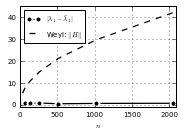

In [27]:
plt.figure(figsize=(2.8,1.8))
plt.plot(SIZES, fst_mu, label=r'$|\lambda_1 - \tilde{\lambda}_1|$', color='black', 
             marker='o', markerfacecolor='black', markeredgecolor='white', markeredgewidth=2)
plt.plot(SIZES, h_mu, linestyle='--', color='black', label=r'Weyl: $\|H\|$', marker='None')
plt.xlabel('$n$')
plt.xlim([0, 2**11+50])
plt.ylim([-1,45])
# plt.plot(SIZES, np.sqrt(SIZES), linestyle='-.', label='$\sqrt{n}$')
plt.legend(loc='upper left')

plt.savefig('./eigvalerr.pgf', bbox_inches='tight')

## Eigenvector error

In [28]:
def first_eigenvector_angle(model, a_vals, a_vecs):
    u = model.eigenvectors[:,-1]
    v = a_vecs[:,-1]
    c = u @ v
    return np.sqrt(1 - c**2)

mu, sigma = average_over_trials(apply_experiment(first_eigenvector_angle))

In [29]:
def first_eigenvector_l_infty(model, a_vals, a_vecs):
    u = model.eigenvectors[:,-1]
    v = a_vecs[:,-1]
    x = np.linalg.norm(u - v, np.inf)
    y = np.linalg.norm(u + v, np.inf)
    
    return min(x, y)

l_infty_mu, l_infty_sigma = average_over_trials(apply_experiment(first_eigenvector_l_infty))

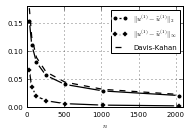

In [19]:
plt.figure(figsize=(2.8,1.8))
plt.plot(SIZES, mu, label=r'$\|u^{(1)} - \tilde{u}^{(1)}\|_2$', color='black', linestyle='-',
            marker='o', markerfacecolor='black', markeredgecolor='white', markeredgewidth=2)
plt.plot(SIZES, l_infty_mu, label=r'$\|u^{(1)} - \tilde{u}^{(1)}\|_\infty$', color='black',
            marker='D', markerfacecolor='black', markeredgecolor='white', markeredgewidth=2)
plt.plot(SIZES, SIZES**(-1/2), linestyle='--', marker='None', label='Davis-Kahan')
plt.xlabel('$n$')
plt.xlim([0, 2**11+50])
# plt.ylim([0,.18])
plt.plot()
plt.legend(loc='best')

import matplotlib.ticker

locator = matplotlib.ticker.MultipleLocator(.05)
ax = plt.gca()
ax.yaxis.set_major_locator(locator)

plt.savefig('./eigvecerr.pgf', bbox_inches='tight')

In [11]:
ax.yaxis.get_majorticklocs()

array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ])